In [1]:
%matplotlib inline
import re
import sys
import math
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict

from evalutils import IntervalForest, populate_index_from_bed, compact
from evalutils import subset_variants_bed, load_kevlar_vcf, load_scalpel_vcf, load_discosnp_vcf, load_gatk_mvf, load_triodenovo_vcf
import kevlar

seaborn.set_context({'figure.figsize': (22, 11)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [2]:
def roc(calls, index, delta=10, fmt='vcf'):
    ncorrect = 0
    num_true_calls_per_false_call = list()
    for varcall in calls:
        if fmt == 'vcf':
            valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        elif fmt == 'mvf':
            callindex, call = varcall
            valid = index.query(call['CHROM'], call['POS'], delta=delta) != set()
        else:
            raise ValueError('unknown format "'+ fmt +'"')
        if valid:
            ncorrect += 1
            continue
        num_true_calls_per_false_call.append(ncorrect)
    if len(num_true_calls_per_false_call) == 0 or ncorrect > num_true_calls_per_false_call[-1]:
        num_true_calls_per_false_call.append(ncorrect)
    return num_true_calls_per_false_call

In [3]:
def doplot(axis, data, color, label, linestyle, symbol, msize, xmax):
    axis.plot(0, data[0], symbol, markersize=msize, color=color, label=label, linestyle=linestyle)
    if len(data) > 1:
        axis.plot(range(len(data))[-1], data[-1], symbol, markersize=msize, color=color)
    axis.plot(range(len(data)), data, color=color, linestyle=linestyle)
    if xmax <= 10:
        axis.plot(range(len(data)), data, symbol, markersize=msize, color=color, markevery=1)

DEBUG cov: 10
DEBUG multi-mapping contig (callclass=227, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1036, mappings=5), FALSE call
DEBUG multi-mapping contig (callclass=156, mappings=2), TRUE call
DEBUG multi-mapping contig (callclass=834, mappings=4), TRUE call
DEBUG multi-mapping contig (callclass=1354, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=1423, mappings=3), TRUE call


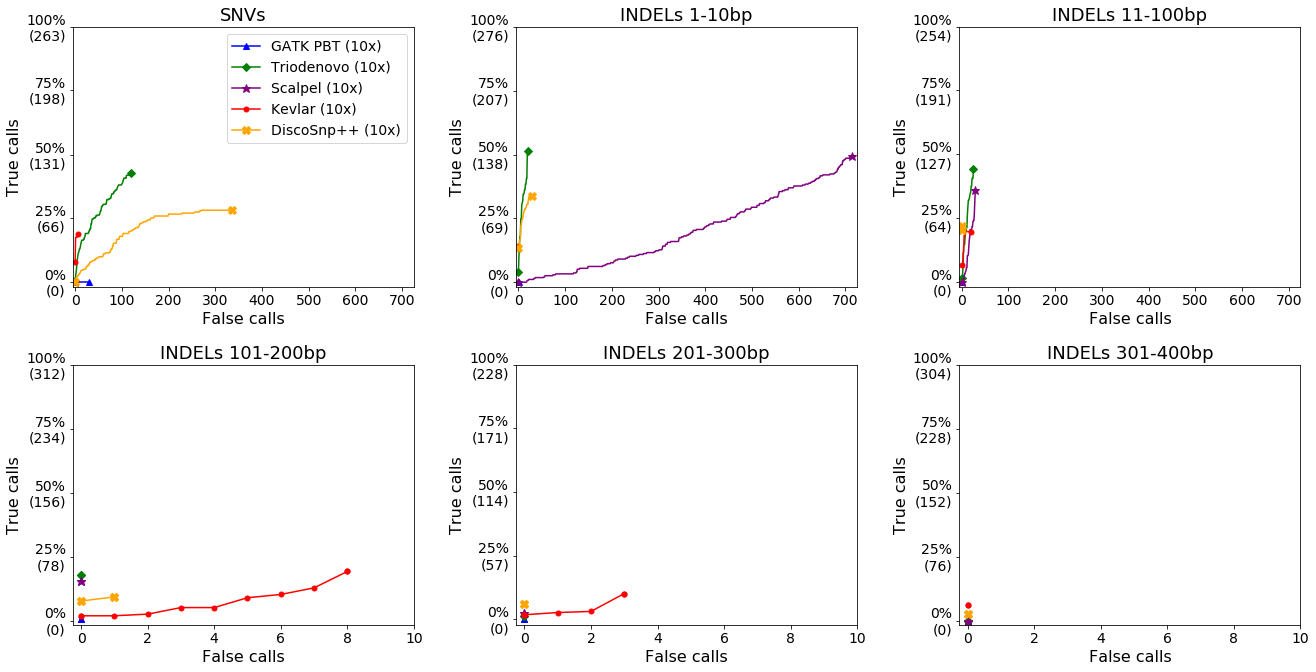

DEBUG cov: 20
DEBUG multi-mapping contig (callclass=21, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=75, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=209, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=167, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=228, mappings=4), FALSE call
DEBUG multi-mapping contig (callclass=240, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=329, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=337, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=387, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=173, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=576, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=999, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=814, mappings=2), TRUE call
DEBUG multi-mapping contig (callclass=834, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=913, mappings

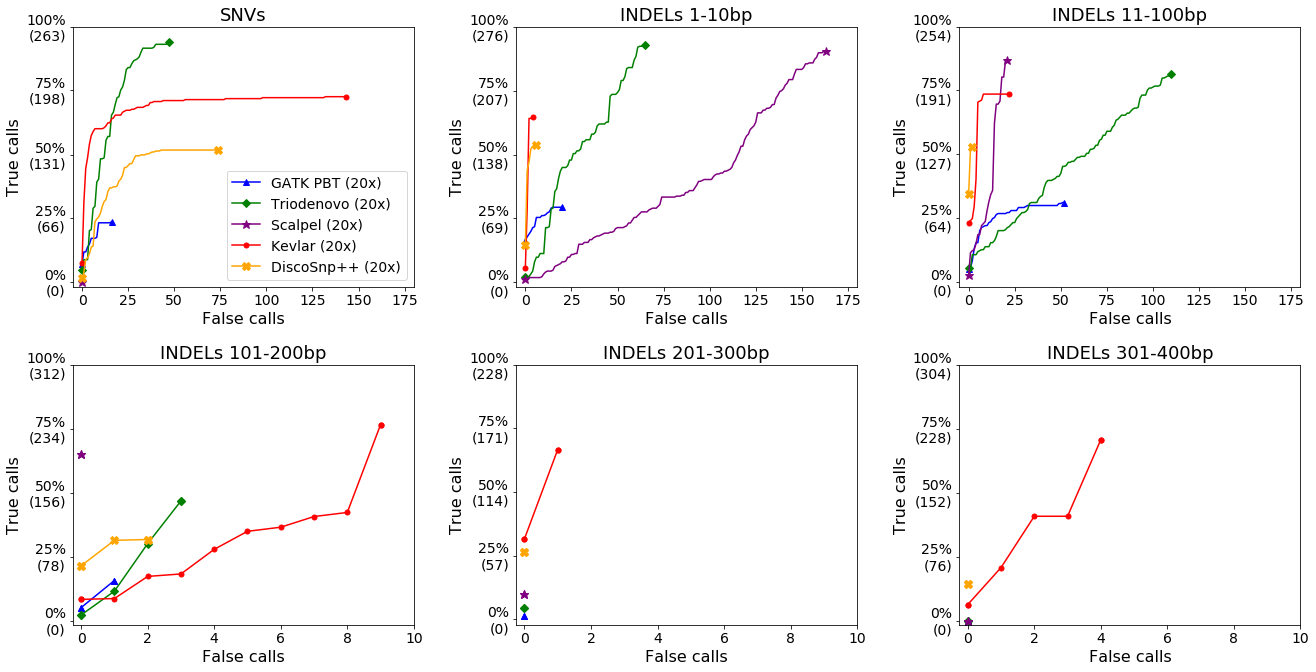

DEBUG cov: 30
DEBUG multi-mapping contig (callclass=45, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=6, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=43, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=101, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=255, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=11, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=105, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=164, mappings=5), FALSE call
DEBUG multi-mapping contig (callclass=122, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=305, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=382, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=384, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=317, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=784, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=170, mappings=4

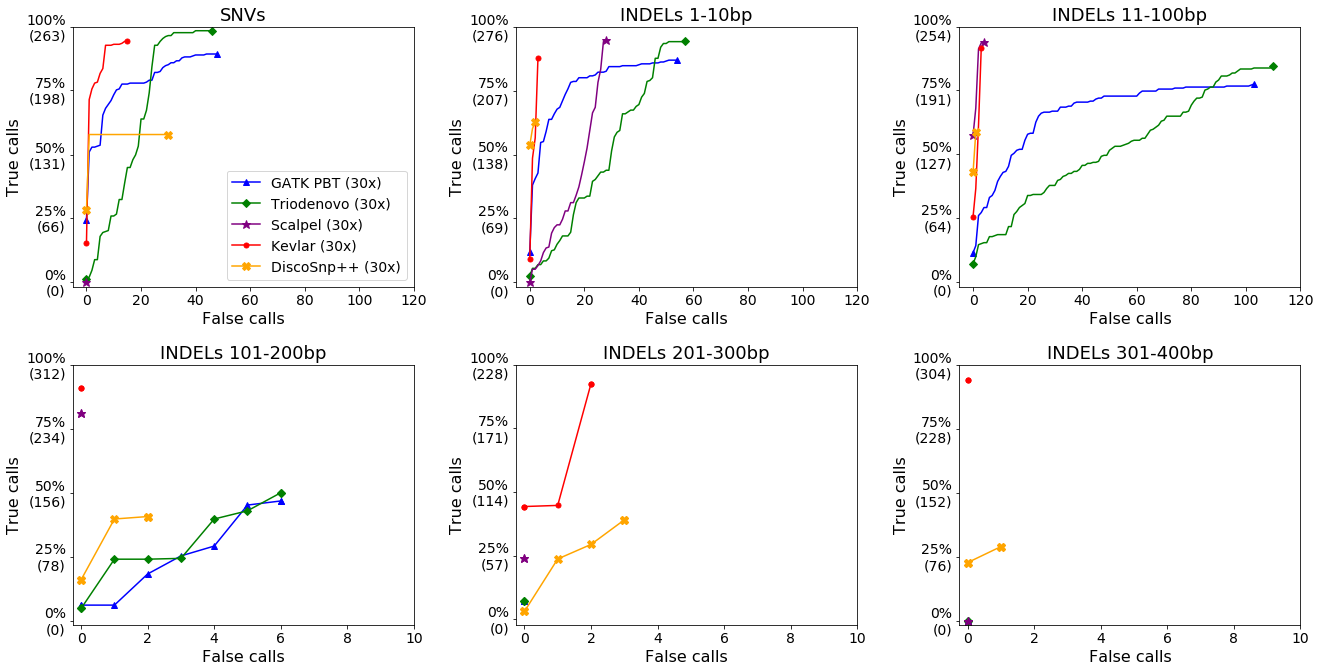

DEBUG cov: 50
DEBUG multi-mapping contig (callclass=58, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=45, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=155, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=111, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=91, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=26, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=177, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=313, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=146, mappings=5), FALSE call
DEBUG multi-mapping contig (callclass=434, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=621, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=596, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=1553, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=254, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1546, mapping

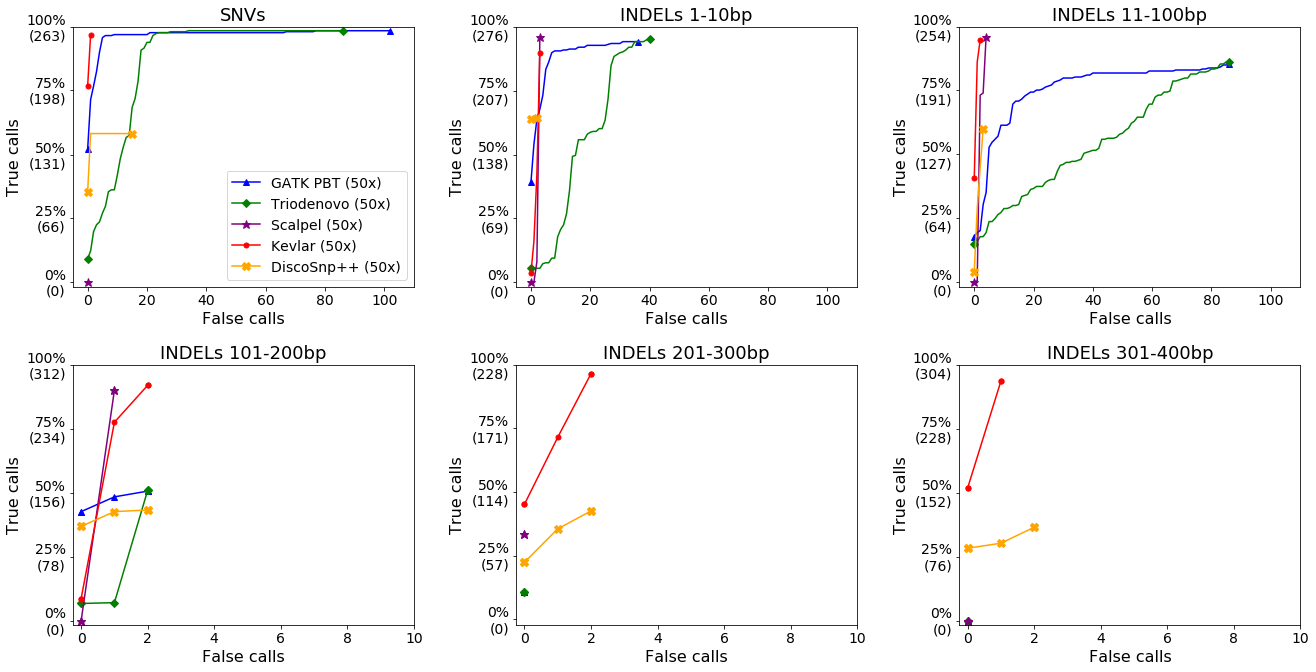

In [4]:
delta = 10
linestyle = '-'
coverage = ('10', '20', '30', '50')
legend_placement = (1, 4, 4, 4)
xmaxes = (725, 180, 120, 110)
#coverage = ['30', '50']
#legend_placement = [4, 4]
#xmaxes = [120, 110]
for cov, legloc, xmax in zip(coverage, legend_placement, xmaxes):
    print('DEBUG cov:', cov)
    seaborn.set_context({'figure.figsize': (22, 11)})
    matplotlib.rcParams['axes.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 14
    matplotlib.rcParams['ytick.labelsize'] = 14
    
    categories = [
        ('SNV', None, None, 'SNVs'),
        ('INDEL', 1, 10, 'INDELs 1-10bp'),
        ('INDEL', 11, 100, 'INDELs 11-100bp'),
        ('INDEL', 101, 200, 'INDELs 101-200bp'),
        ('INDEL', 201, 300, 'INDELs 201-300bp'),
        ('INDEL', 301, 400, 'INDELs 301-400bp'),
    ]
    fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3)
    axes = (ax11, ax12, ax13, ax21, ax22, ax23)
    seaborn.set_context({'figure.figsize': (24, 12)})
    
    for i, (category, axis) in enumerate(zip(categories, axes)):
        vartype, minlength, maxlength, label = category
        with kevlar.open('SimulatedVariants_chr17_hg38_markII.bed', 'r') as instream:
            variants = subset_variants_bed(instream, vartype, minlength, maxlength)
            index = populate_index_from_bed(variants)
        
            kevlar_truecalls = roc(
                load_kevlar_vcf(
                    'kevlar-'+cov+'x-binomscore-nohomopoly-noabundfilt.vcf.gz', index, delta=delta,
                    vartype=vartype, minlength=minlength, maxlength=maxlength, debug=(i==0),
                ),
                index, delta=delta, fmt='vcf'
            )
            scalpel_truecalls = roc(
                load_scalpel_vcf(
                    'scalpel.'+ cov +'x.denovo.indel.vcf', cov=cov,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            discosnp_truecalls = roc(
                load_discosnp_vcf(
                    'discosnp.'+ cov +'x.vcf.gz', cov=cov, applyfilters=False,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            gatk_truecalls = roc(
                load_gatk_mvf(
                    'JointCall-'+ cov +'x-PBT.mvf',
                    vartype=vartype, minlength=minlength, maxlength=maxlength
                ).iterrows(),
                index, delta=delta, fmt='mvf'
            )
            triodenovo_truecalls = roc(
                load_triodenovo_vcf(
                    'JointCall-'+ cov +'x-TDN.vcf', cov=cov,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            
            if i > 2:
                xmax = 10
            
            doplot(axis, gatk_truecalls, 'blue', 'GATK PBT ({}x)'.format(cov), linestyle, '^', 6, xmax)
            doplot(axis, triodenovo_truecalls, 'green', 'Triodenovo ({}x)'.format(cov), linestyle, 'D', 5, xmax)
            doplot(axis, scalpel_truecalls, 'purple', 'Scalpel ({}x)'.format(cov), linestyle, '*', 9, xmax)
            doplot(axis, kevlar_truecalls, 'red', 'Kevlar ({}x)'.format(cov), linestyle, 'o', 5, xmax)
            doplot(axis, discosnp_truecalls, 'orange', 'DiscoSnp++ ({}x)'.format(cov), linestyle, 'X', 8, xmax)
            
            nvariants = len(index.trees['chr17'])
            ticknums = [0, math.ceil(nvariants * 0.25), int(nvariants * 0.5), math.ceil(nvariants * 0.75), nvariants]
            ticklabels = ['{:d}%\n({:d})'.format(round(tn / nvariants * 100), tn) for tn in ticknums]
            
            _ = axis.set_xlabel('False calls', fontsize=16)
            if i > 2:
                _ = axis.set_xlim(-0.25, 10)
                _ = axis.set_xticks(list(range(0, 11, 2)))
            else:
                _ = axis.set_xlim((-5, xmax))
            _ = axis.set_yticks(ticknums)
            _ = axis.set_yticklabels(ticklabels)
            _ = axis.set_ylabel('True calls', fontsize=16)
            _ = axis.set_ylim((-5, nvariants))
            _ = axis.set_title(label, fontsize=18)
            if i == 0:
                _ = axis.legend(fontsize=14, loc=legloc)
    
    _ = plt.subplots_adjust(hspace=0.3, wspace=0.3)
    _ = plt.savefig('five-callers-'+ cov +'x-combined-sep.pdf', dpi=300)
    _ = plt.show()

DEBUG cov: 10
DEBUG multi-mapping contig (callclass=10, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=200, mappings=4), FALSE call
DEBUG multi-mapping contig (callclass=1328, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=8388, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1125, mappings=3), TRUE call
DEBUG multi-mapping contig (callclass=1701, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=2934, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=1081, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=10240, mappings=9), FALSE call
DEBUG multi-mapping contig (callclass=1800, mappings=3), TRUE call
DEBUG multi-mapping contig (callclass=4744, mappings=8), FALSE call
DEBUG multi-mapping contig (callclass=1425, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=638, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=6446, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=2

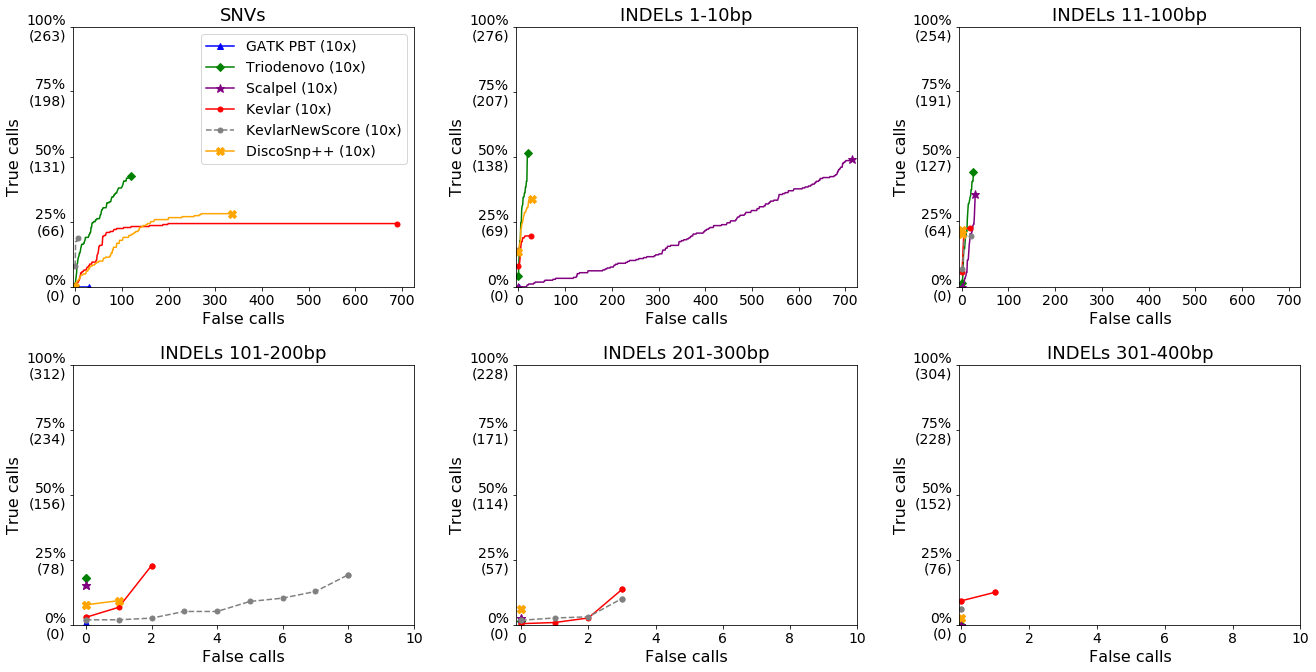

DEBUG cov: 20
DEBUG multi-mapping contig (callclass=21, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=201, mappings=7), FALSE call
DEBUG multi-mapping contig (callclass=73, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=357, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=603, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1019, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1142, mappings=5), FALSE call
DEBUG multi-mapping contig (callclass=468, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=406, mappings=2), TRUE call
DEBUG multi-mapping contig (callclass=1405, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=1192, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1907, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=832, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1204, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=617, ma

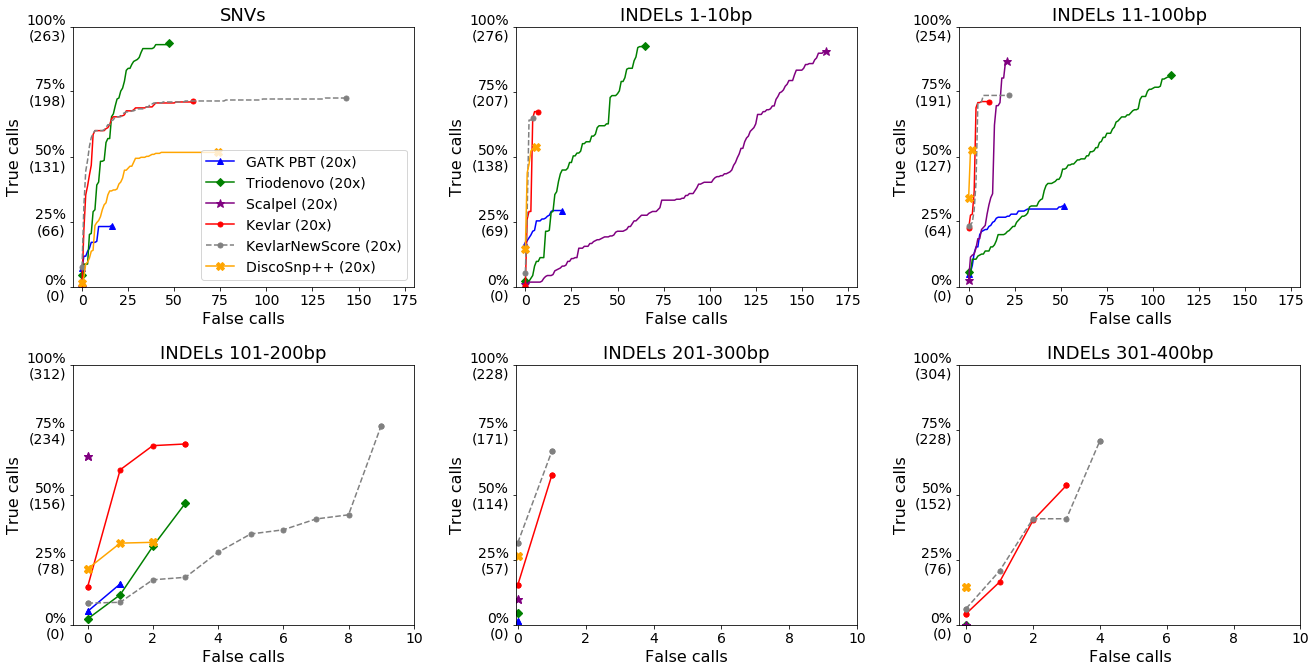

DEBUG cov: 30
DEBUG multi-mapping contig (callclass=45, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=8, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=43, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=101, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=5, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=141, mappings=7), FALSE call
DEBUG multi-mapping contig (callclass=164, mappings=6), FALSE call
DEBUG multi-mapping contig (callclass=165, mappings=5), FALSE call
DEBUG multi-mapping contig (callclass=123, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=383, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=306, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=272, mappings=9), FALSE call
DEBUG multi-mapping contig (callclass=171, mappings=4), FALSE call
DEBUG multi-mapping contig (callclass=390, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1189, mappings=2

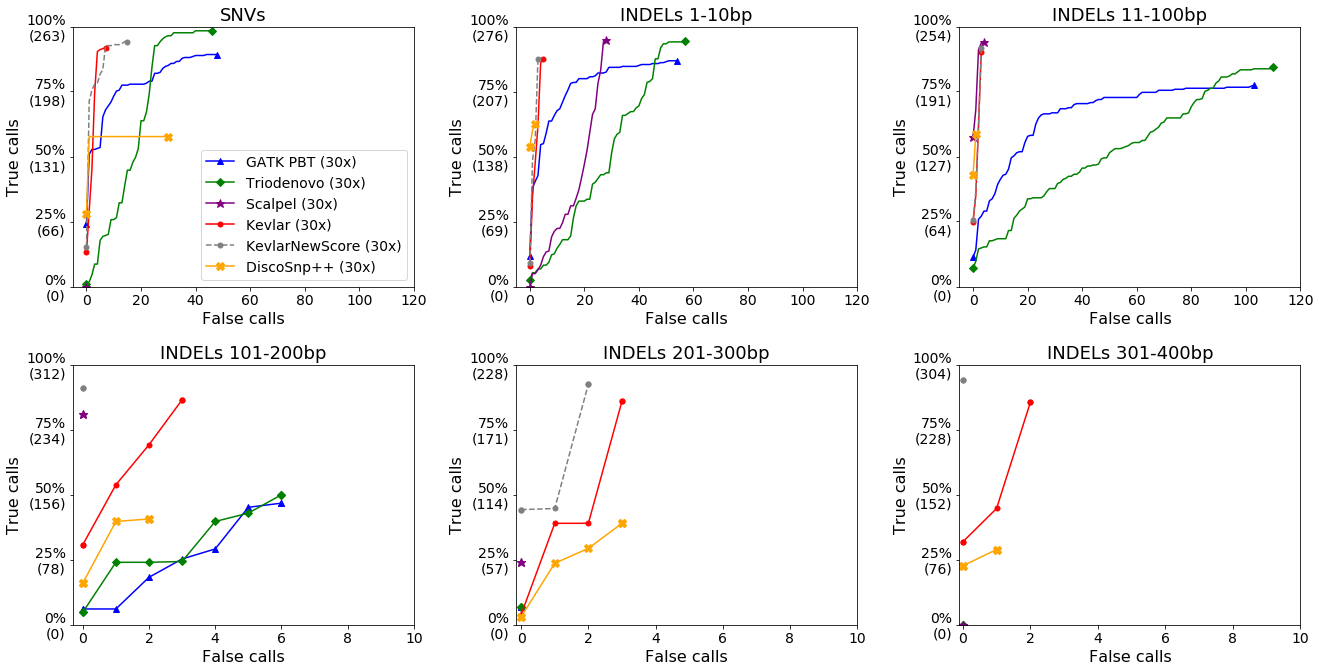

DEBUG cov: 50
DEBUG multi-mapping contig (callclass=58, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=45, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=155, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=26, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=17, mappings=8), FALSE call
DEBUG multi-mapping contig (callclass=177, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=314, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=146, mappings=5), FALSE call
DEBUG multi-mapping contig (callclass=434, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=254, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=622, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=237, mappings=4), FALSE call
DEBUG multi-mapping contig (callclass=1064, mappings=2), FALSE call
DEBUG multi-mapping contig (callclass=1548, mappings=3), FALSE call
DEBUG multi-mapping contig (callclass=1394, mappin

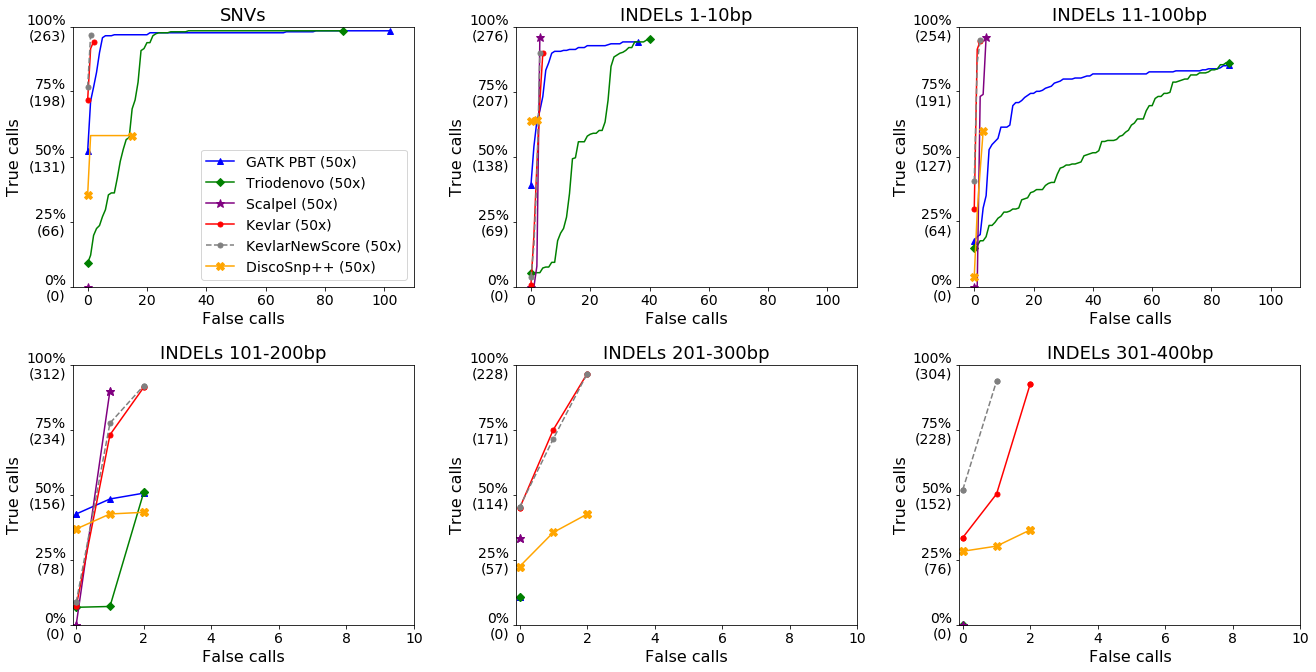

In [5]:
delta = 10
linestyle = '-'
coverage = ('10', '20', '30', '50')
legend_placement = (1, 4, 4, 4)
xmaxes = (725, 180, 120, 110)
#coverage = ['30', '50']
#legend_placement = [4, 4]
#xmaxes = [120, 110]
for cov, legloc, xmax in zip(coverage, legend_placement, xmaxes):
    print('DEBUG cov:', cov)
    seaborn.set_context({'figure.figsize': (22, 11)})
    matplotlib.rcParams['axes.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 14
    matplotlib.rcParams['ytick.labelsize'] = 14
    
    categories = [
        ('SNV', None, None, 'SNVs'),
        ('INDEL', 1, 10, 'INDELs 1-10bp'),
        ('INDEL', 11, 100, 'INDELs 11-100bp'),
        ('INDEL', 101, 200, 'INDELs 101-200bp'),
        ('INDEL', 201, 300, 'INDELs 201-300bp'),
        ('INDEL', 301, 400, 'INDELs 301-400bp'),
    ]
    fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3)
    axes = (ax11, ax12, ax13, ax21, ax22, ax23)
    seaborn.set_context({'figure.figsize': (24, 12)})
    
    for i, (category, axis) in enumerate(zip(categories, axes)):
        vartype, minlength, maxlength, label = category
        with kevlar.open('SimulatedVariants_chr17_hg38_markII.bed', 'r') as instream:
            variants = subset_variants_bed(instream, vartype, minlength, maxlength)
            index = populate_index_from_bed(variants)
        
            kevlar_truecalls = roc(
                load_kevlar_vcf(
                    'kevlar-calls-'+ cov +'x-nohomopoly-ambig-thresh.vcf.gz', index, delta=delta,
                    vartype=vartype, minlength=minlength, maxlength=maxlength, debug=(i==0),
                ),
                index, delta=delta, fmt='vcf'
            )
            kevlar_truecalls_prime = roc(
                load_kevlar_vcf(
                    'kevlar-'+cov+'x-binomscore-nohomopoly-noabundfilt.vcf.gz', index, delta=delta,
                    vartype=vartype, minlength=minlength, maxlength=maxlength, debug=(i==0),
                ),
                index, delta=delta, fmt='vcf'
            )
            scalpel_truecalls = roc(
                load_scalpel_vcf(
                    'scalpel.'+ cov +'x.denovo.indel.vcf', cov=cov,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            discosnp_truecalls = roc(
                load_discosnp_vcf(
                    'discosnp.'+ cov +'x.vcf.gz', cov=cov, applyfilters=False,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            gatk_truecalls = roc(
                load_gatk_mvf(
                    'JointCall-'+ cov +'x-PBT.mvf',
                    vartype=vartype, minlength=minlength, maxlength=maxlength
                ).iterrows(),
                index, delta=delta, fmt='mvf'
            )
            triodenovo_truecalls = roc(
                load_triodenovo_vcf(
                    'JointCall-'+ cov +'x-TDN.vcf', cov=cov,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            
            if i > 2:
                xmax = 10
            
            doplot(axis, gatk_truecalls, 'blue', 'GATK PBT ({}x)'.format(cov), linestyle, '^', 6, xmax)
            doplot(axis, triodenovo_truecalls, 'green', 'Triodenovo ({}x)'.format(cov), linestyle, 'D', 5, xmax)
            doplot(axis, scalpel_truecalls, 'purple', 'Scalpel ({}x)'.format(cov), linestyle, '*', 9, xmax)
            doplot(axis, kevlar_truecalls, 'red', 'Kevlar ({}x)'.format(cov), linestyle, 'o', 5, xmax)
            doplot(axis, kevlar_truecalls_prime, 'grey', 'KevlarNewScore ({}x)'.format(cov), '--', 'o', 5, xmax)
            doplot(axis, discosnp_truecalls, 'orange', 'DiscoSnp++ ({}x)'.format(cov), linestyle, 'X', 8, xmax)
            
            nvariants = len(index.trees['chr17'])
            ticknums = [0, math.ceil(nvariants * 0.25), int(nvariants * 0.5), math.ceil(nvariants * 0.75), nvariants]
            ticklabels = ['{:d}%\n({:d})'.format(round(tn / nvariants * 100), tn) for tn in ticknums]
            
            _ = axis.set_xlabel('False calls', fontsize=16)
            if i > 2:
                _ = axis.set_xticks(list(range(0, 11, 2)))
            else:
                _ = axis.set_xlim((-5, xmax))
            _ = axis.set_yticks(ticknums)
            _ = axis.set_yticklabels(ticklabels)
            _ = axis.set_ylabel('True calls', fontsize=16)
            _ = axis.set_ylim((0, nvariants))
            _ = axis.set_title(label, fontsize=18)
            if i == 0:
                _ = axis.legend(fontsize=14, loc=legloc)
    
    _ = plt.subplots_adjust(hspace=0.3, wspace=0.3)
    # _ = plt.savefig('five-callers-'+ cov +'x-combined-sep.pdf', dpi=300)
    _ = plt.show()